In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion() # interactive mode(Matplotlib의 대화형 모드 활성화)
# 대화형 모드에서는 plt.show()를 호출하지 않아도 차트가 자동으로 화면에 나타남(GUI app에서 유용)


In [2]:
# Data augmentation and normalization
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = os.path.join(os.getcwd(), "hymenoptera_data")
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

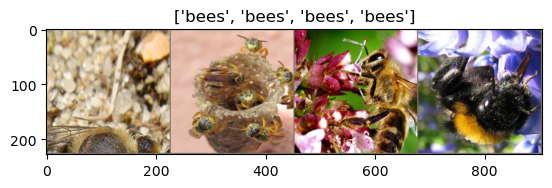

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None: 
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epoches=25):
    since = time.time()

    # Create Temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epoches):
            print(f"Epoch {epoch} / {num_epoches - 1}")
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train' :
                    model.train()
                else:
                    model.eval()
                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f" {phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}")

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
        time_elapsed = time.time() - since
        print(f"Training Complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}")
        print(f"Best Validate Accuracy : {best_acc:.4f}")
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"predicted : {class_names[preds[j]]}")
                imshow(inputs.data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
# Load a pretrained model and reset final fully connected layer
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 출력은 ANT, BEE만 있으니 output sample is set to 2
# can be generalized to 'nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/jeonghyeonjin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epoches=10)

Epoch 0 / 9
----------
 train Loss : 0.5251 Acc : 0.7172
 val Loss : 0.6202 Acc : 0.7124
Epoch 1 / 9
----------
 train Loss : 0.5538 Acc : 0.7459
 val Loss : 0.2652 Acc : 0.9281
Epoch 2 / 9
----------
 train Loss : 0.4723 Acc : 0.7992
 val Loss : 0.2680 Acc : 0.8889
Epoch 3 / 9
----------
 train Loss : 0.4563 Acc : 0.8115
 val Loss : 0.3305 Acc : 0.8758
Epoch 4 / 9
----------
 train Loss : 0.4806 Acc : 0.8361
 val Loss : 0.5383 Acc : 0.8105
Epoch 5 / 9
----------
 train Loss : 0.5299 Acc : 0.7869
 val Loss : 0.5001 Acc : 0.8105
Epoch 6 / 9
----------
 train Loss : 0.5230 Acc : 0.7869
 val Loss : 0.3242 Acc : 0.8693
Epoch 7 / 9
----------
 train Loss : 0.3617 Acc : 0.8770
 val Loss : 0.3137 Acc : 0.8824
Epoch 8 / 9
----------
 train Loss : 0.2930 Acc : 0.8730
 val Loss : 0.2820 Acc : 0.9085
Epoch 9 / 9
----------
 train Loss : 0.3618 Acc : 0.8443
 val Loss : 0.2993 Acc : 0.9085
Training Complete in 11m 47
Best Validate Accuracy : 0.9281


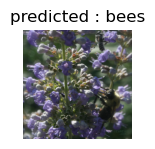

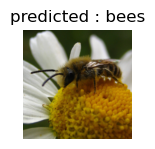

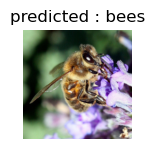

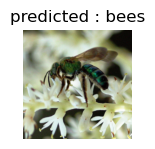

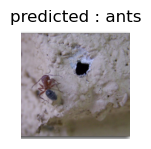

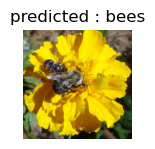

In [12]:
visualize_model(model_ft)

In [13]:
# ConvNet as fixed feautre extractor
# final layer 말고는 freeze 해야 함. 따라서, requires_grad=False로 freeze를 수행해야 함
# 이를 통해 freeze한 parameters의 gradient는 역전파 과정으로 연산되지 않음

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Pre-trained된 모델의 학습과 달리 Freeze시킨 Conv 층이 존재
# 즉, Final Layer만 Optimize하면됨
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epoches=10)
# 이전의 pretrained 모델 fine-tuning 할때 대비 절반정도의 학습시간이 요소됨. 

Epoch 0 / 9
----------
 train Loss : 0.6001 Acc : 0.7131
 val Loss : 0.2156 Acc : 0.9346
Epoch 1 / 9
----------
 train Loss : 0.3734 Acc : 0.8115
 val Loss : 0.2263 Acc : 0.9020
Epoch 2 / 9
----------
 train Loss : 0.4711 Acc : 0.8074
 val Loss : 0.2543 Acc : 0.9085
Epoch 3 / 9
----------
 train Loss : 0.5961 Acc : 0.7623
 val Loss : 0.4032 Acc : 0.8301
Epoch 4 / 9
----------
 train Loss : 0.7596 Acc : 0.7377
 val Loss : 0.2802 Acc : 0.9020
Epoch 5 / 9
----------
 train Loss : 0.4577 Acc : 0.8238
 val Loss : 0.1800 Acc : 0.9346
Epoch 6 / 9
----------
 train Loss : 0.3440 Acc : 0.8566
 val Loss : 0.2218 Acc : 0.9346
Epoch 7 / 9
----------
 train Loss : 0.3326 Acc : 0.8566
 val Loss : 0.1684 Acc : 0.9477
Epoch 8 / 9
----------
 train Loss : 0.3234 Acc : 0.8566
 val Loss : 0.1865 Acc : 0.9346
Epoch 9 / 9
----------
 train Loss : 0.5038 Acc : 0.7746
 val Loss : 0.1950 Acc : 0.9281
Training Complete in 9m 44
Best Validate Accuracy : 0.9477


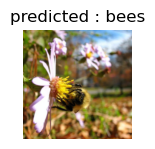

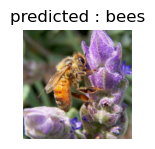

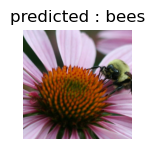

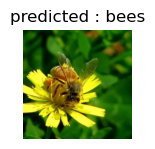

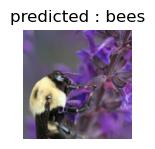

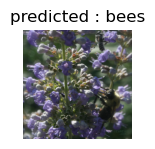

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [20]:
# 따로 불러오는 이미지에 대해서 Inference Task 수행
def visualize_model_predictions(model, image_path):
    was_training = model.training
    model.eval()
    
    image = Image.open(image_path)
    image = data_transforms['val'](image)
    image = image.unsqueeze(0)
    # image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        
        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f"predicted : {class_names[preds[0]]}")
        imshow(image.cpu().data[0])

        model.train(mode=was_training)

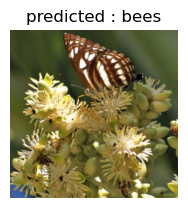

In [21]:
visualize_model_predictions(
    model_conv,
    image_path='./hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)
plt.ioff()
plt.show()